<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/Exploration07/fashion_mnist_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Keras Tuner 라이브러리를 설치
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.1 MB/s eta 0:00:00


In [2]:
# TensorFlow와 scikit-learn 라이브러리를 이용해 Fashion MNIST 데이터셋을 불러오고
# 이를 학습, 검증, 테스트 데이터로 나누는 과정
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full,
                                                  test_size=0.3,
                                                  random_state=123)

print(f"전체 학습 데이터: {x_train_full.shape} 레이블: {y_train_full.shape}")
print(f"학습 데이터: {x_train.shape} 레이블: {y_train.shape}")
print(f"검증 데이터: {x_val.shape} 레이블: {y_val.shape}")
print(f"테스트 데이터: {x_test.shape} 레이블: {y_test.shape}")

4422102/4422102 [==============================] - 1s 0us/step
전체 학습 데이터: (60000, 28, 28) 레이블: (60000,)
학습 데이터: (42000, 28, 28) 레이블: (42000,)
검증 데이터: (18000, 28, 28) 레이블: (18000,)
테스트 데이터: (10000, 28, 28) 레이블: (10000,)


In [3]:
# TensorFlow, Keras, 그리고 Keras Tuner 라이브러리를 임포트
import tensorflow as tf
import keras
import keras_tuner as kt
import os

# CNN을 사용할 예정이라 차원 수를 하나 더 추가해줍니다.
# label을 categorical을 활용해 변환합니다.​
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

y_train[0]

Using TensorFlow backend
(42000, 28, 28, 1)
(18000, 28, 28, 1)
(10000, 28, 28, 1)


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [4]:
x_train = x_train / 255. # 정규화
x_val = x_val / 255.
x_test = x_test / 255.

In [5]:
# Keras Tuner 라이브러리를 활용하여 하이퍼파라미터 튜닝을 수행하는 사용자 정의 클래스 DeepTuner를 정의
class DeepTuner(kt.Tuner):
   def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
       model = self.hypermodel.build(trial.hyperparameters)
       model.fit(X, y, batch_size=trial.hyperparameters.Choice(
           'batch_size', [16, 32]), **fit_kwargs) # batch_size는 하이퍼파라미터로서 16 또는 32 중에서 선택
       x_val, y_val = validation_data
       eval_scores = model.evaluate(x_val, y_val)
       return {name: value for name, value in zip(
           model.metrics_names,
           eval_scores)}

In [6]:
def build_model(hp):
   model = tf.keras.Sequential()
   model.add(tf.keras.Input(shape = x_train.shape[1:], name = 'inputs'))
   for i in range(hp.Int('num_layers', min_value=1, max_value=10)): # 1개에서 10개까지의 Conv2D 레이어를 추가
             model.add(tf.keras.layers.Conv2D(hp.Int(
                 'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu')) # 필터수는 32부터 128까지 5의 간격으로 설정
   model.add(tf.keras.layers.Flatten())
   for i in range(hp.Int('n_connections', 1, 3)): # 1개에서 3개까지의 완전 연결 레이어(Dense layer)를 추가
       model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                 values=[32,64,128, 256]), activation = 'relu')) # 노드 수는 [32, 64, 128, 256] 중 하나로 설
   model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
   model.compile(optimizer = 'adam',loss='categorical_crossentropy',
       metrics=['accuracy'])
   return model

In [7]:
# Keras Tuner 라이브러리를 활용하여 하이퍼파라미터 튜닝을 수행하는 사용자 정의 클래스 DeepTuner를 정의
my_keras_tuner = DeepTuner(
   oracle=kt.oracles.BayesianOptimizationOracle(
       objective=kt.Objective('accuracy', 'max'),
       max_trials=10,  # 총 10번의 시도
       seed=42),
   hypermodel=build_model,
   overwrite=True,
   project_name='my_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
   x_train, y_train, validation_data=(x_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 46s]
accuracy: 0.8581110835075378

Best accuracy So Far: 0.901888906955719
Total elapsed time: 00h 08m 46s


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Keras Tuner를 사용해 획득한 최적의 하이퍼파라미터를 사용하여 모델을 생성하고, 그 모델의 구조를 출력
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0] # [0]은 가장 좋은 하이퍼파라미터 세트만을 선택
model = build_model(best_hps)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 26, 26, 67)        670       
                                                                 
 conv2d_66 (Conv2D)          (None, 24, 24, 87)        52548     
                                                                 
 flatten_11 (Flatten)        (None, 50112)             0         
                                                                 
 dense_16 (Dense)            (None, 32)                1603616   
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 outputs (Dense)             (None, 10)                330       
                                                                 
Total params: 1658220 (6.33 MB)
Trainable params: 165

In [10]:
# 모델 학습 과정
history = model.fit(x_train, y_train, batch_size=32, epochs = 10, validation_data=(x_val, y_val))

Epoch 1/10
1313/1313 [==============================] - 11s 6ms/step - loss: 0.4436 - accuracy: 0.8443 - val_loss: 0.3182 - val_accuracy: 0.8856
Epoch 2/10
1313/1313 [==============================] - 9s 7ms/step - loss: 0.2743 - accuracy: 0.8997 - val_loss: 0.2956 - val_accuracy: 0.8943
Epoch 3/10
1313/1313 [==============================] - 9s 6ms/step - loss: 0.2148 - accuracy: 0.9199 - val_loss: 0.2713 - val_accuracy: 0.9030
Epoch 4/10
1313/1313 [==============================] - 10s 7ms/step - loss: 0.1669 - accuracy: 0.9371 - val_loss: 0.2776 - val_accuracy: 0.9028
Epoch 5/10
1313/1313 [==============================] - 8s 6ms/step - loss: 0.1288 - accuracy: 0.9520 - val_loss: 0.3093 - val_accuracy: 0.9018
Epoch 6/10
1313/1313 [==============================] - 8s 6ms/step - loss: 0.0978 - accuracy: 0.9635 - val_loss: 0.3162 - val_accuracy: 0.9066
Epoch 7/10
1313/1313 [==============================] - 8s 6ms/step - loss: 0.0709 - accuracy: 0.9743 - val_loss: 0.3712 - val_accurac

In [11]:
# 모델 model을 테스트 데이터셋 x_test와 y_test에 대해 평가
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5213 - accuracy: 0.9092


[0.5213473439216614, 0.9092000126838684]

In [12]:
# 학습된 딥러닝 모델을 파일로 저장
path = '/content/drive/MyDrive/mlops/model'
model.save(path)

In [13]:
# TensorFlow Lite(TFLite) 형식으로 Keras 모델을 변환하고, 변환된 모델의 서명(signature)을 출력
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['inputs'], 'outputs': ['outputs']}}


In [28]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [14]:
with open('/content/drive/MyDrive/mlops/model/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [15]:
def show_history(history):
    history_dict = history.history

    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b-', label='train_loss')
    ax1.plot(epochs, val_loss, 'r-', label='val_loss')
    ax1.set_title('Train and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
    ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
    ax2.set_title('Train and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

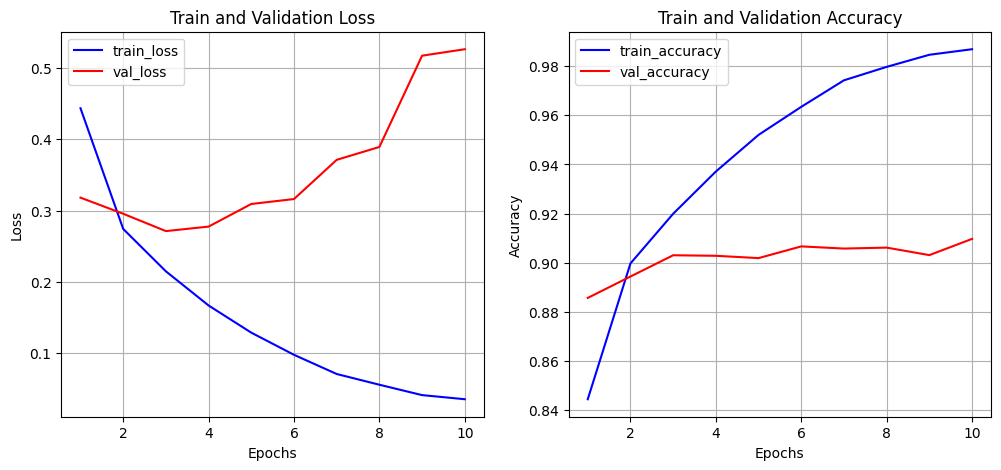

In [16]:
import matplotlib.pyplot as plt
import numpy as np
show_history(history)

# 회고
TFX 개념도 낯설고 내용도 어렵고 구현은 더더욱 힘듭니다.
대신 케라스 튜너는 아주 유형합니다. 기존에 모델 파인 튜닝 시 매번 하던 삽질을 더 이상 하지 않아도 될 듯합니다.
탠서플로 서버는 구현에 실패했지만 다시 도전.
참고로 지난번 패션 MNIST 파인 튜닝 결과가 정확도가 85%인데 이번엔 한방에 90%라 일단 이번 노드 만족합니다.